In [1]:
%load_ext autoreload
%autoreload 2

### Setup (Pull W&B Logs)

In [2]:
from olmo.scaling.scaling_laws.download_wandb_logs import main as download_wb
from a_david_noise_utils import get_name_size_length
from argparse import Namespace
import os
import itertools

WANDB_RESULTS = "wandb/peteish-final"
FIGURES = "figures"

run_names = [
    f"ai2-llm/olmo-ladder/peteish-final-{size}-{length}"
    for size, length in itertools.product(["190M", "370M", "600M", "760M", "1B"], ["1xC", "2xC", "5xC", "10xC"])
]

validation_outputs = {}
for run_name in run_names:
    if "peteish7" in run_name:
        output_name = "peteish7"
    else:
        output_name = run_name.split("/")[-1]
        name, size, length = get_name_size_length(run_name)
        output_name = f"{size}-{length}"
    output_path = f"{WANDB_RESULTS}/{output_name}.csv"
    args = Namespace(
        wandb_names=[run_name],
        x_axis="throughput/total_tokens",
        y_axis=["eval/validation-and-bpb-and-downstream"],
        output_path=output_path,
    )
    if not os.path.exists(output_path):
        download_wb(args)
    validation_outputs[output_name] = output_path

/Users/dhei/miniconda3/envs/olmo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Hard Setting

In [3]:
import ladder_peteish as ladder

# Find the model size corresponding to 10x less compute
all_flops = []
for size in ["190M", "370M", "600M", "760M", "1B", "3B"]:
    paths = []
    for length in ["1xC", "2xC", "5xC", "10xC"]:
        if size == "3B" and length == "10xC":
            break
        model_flops = ladder.MODEL_GFLOPS[size]
        length_in_tokens = ladder.parse_length(length, ladder.parse_size(size))
        total_flops = (model_flops * length_in_tokens) / 1e18
        all_flops.append((f"{size}-{length}", total_flops))
sorted_by_flops = sorted(all_flops, key=lambda x:x[1])
corresponding_flops_10x = {
    "1B-10xC": "1B-1xC",
}

In [4]:
sorted_by_flops

[('190M-1xC', 5.78262484353024),
 ('190M-2xC', 11.56524968706048),
 ('370M-1xC', 21.765149207014932),
 ('190M-5xC', 28.9131242176512),
 ('370M-2xC', 43.530298414029865),
 ('600M-1xC', 53.85819379339542),
 ('190M-10xC', 57.8262484353024),
 ('760M-1xC', 84.99363997969023),
 ('600M-2xC', 107.71638758679084),
 ('370M-5xC', 108.82574603507466),
 ('760M-2xC', 169.98727995938046),
 ('370M-10xC', 217.65149207014932),
 ('1B-1xC', 232.43283455771936),
 ('600M-5xC', 269.2909689669771),
 ('760M-5xC', 424.96819989845113),
 ('1B-2xC', 464.8656691154387),
 ('600M-10xC', 538.5819379339542),
 ('760M-10xC', 849.9363997969023),
 ('1B-5xC', 1162.1641727885967),
 ('3B-1xC', 1350.4839740687253),
 ('1B-10xC', 2324.3283455771934),
 ('3B-2xC', 2700.9679481374505),
 ('3B-5xC', 6752.419870343627)]

In [5]:
from a_david_noise_utils import COLOR_MAP
from olmo.scaling.scaling_laws.utils import FinalConfig

all_configs = []

for run_name, max_train_run in corresponding_flops_10x.items():
    configs_size = {}
    for (train_run, _) in sorted_by_flops:
        
        train_size, train_length = train_run.split("-")
        if train_size in configs_size:
            configs_size[train_size]["paths"].append(f"wandb/peteish-final/{train_run}.csv")
        else:
            configs_size[train_size] = {
                "paths": [f"wandb/peteish-final/{train_run}.csv"],
                "mode": "train",
                "n": ladder.MODEL_PARAMS[train_size],
                "label": train_size,
                "color": COLOR_MAP[train_size]
            }

        if train_run == max_train_run:
            break

    size, length = run_name.split("-")
    configs_size[f"{size}-{length}"] = {
        "paths": [f"wandb/peteish-final/{run_name}.csv"],
        "mode": "eval",
        "n": ladder.MODEL_PARAMS[size],
        "label": size,
        "color": COLOR_MAP[size]
    }
    configs_size = {name: FinalConfig(**config) for name, config in configs_size.items()}
    all_configs.append(configs_size)

#### Predicting 1B at 10xC

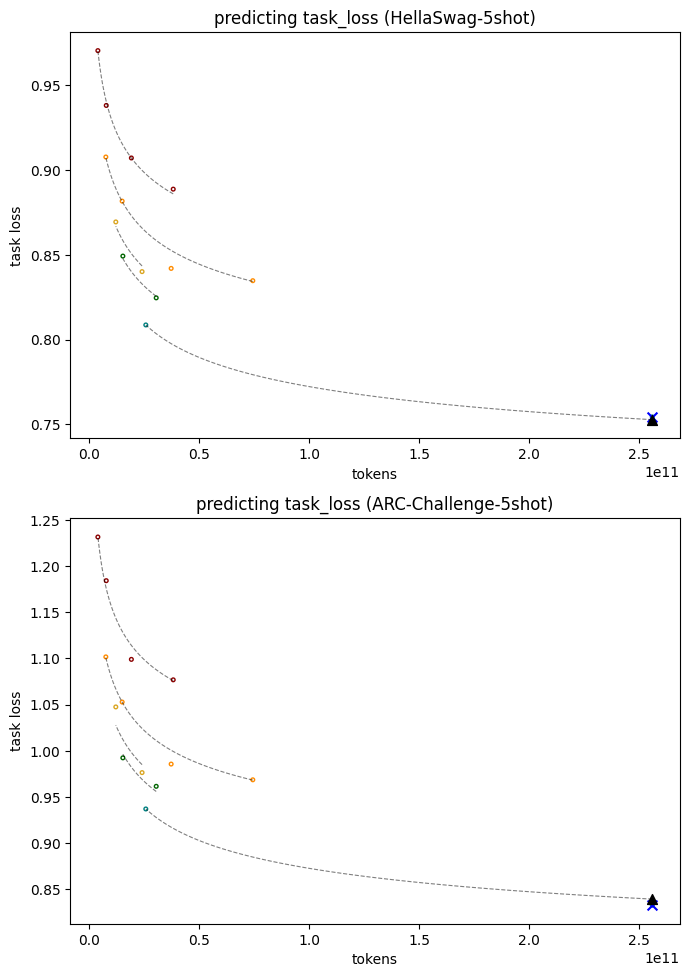

In [6]:
from a_david_noise_utils import get_all_data_by_name, get_dataframe, plot_step1, plot_step2, fit_step1, fit_step2, get_predicted_error, plot_stacked
from a_david_noise_utils import BASELINE_BY_TASK_NAME, TASKS

import matplotlib.pyplot as plt

rows = len(TASKS.keys())

plot_step_1_only = True

if plot_step_1_only:
    fig, axes = plt.subplots(rows, 1, figsize=(7, 5 * rows))
else:
    fig, axes = plt.subplots(rows, 3, figsize=(20, 5 * rows))

step1_error = {}
stacked_error = {}

for configs in all_configs:
    target = [run_name for run_name in configs if configs[run_name].mode == "eval"][0]
    step1_error[target] = {}
    stacked_error[target] = {}

    for i, (task_name, task) in enumerate(TASKS.items()):
        tokens = get_all_data_by_name(configs, ["throughput/total_tokens"])
        bpb_loss = get_all_data_by_name(configs, task['bpb'])
        downstream_loss = get_all_data_by_name(configs, task['score'])
    
        df = get_dataframe(configs, tokens, downstream_loss)
        
        step1_df = get_dataframe(configs, tokens, bpb_loss)

        # Only keep the final result from each run
        step1_df = step1_df.groupby('run').apply(lambda rows: rows.iloc[-1], include_groups=False).reset_index()
        step1_df, coefficients = fit_step1(step1_df)

        # Only plot error for predicted point
        do_plot = "1B-10xC" in configs

        if do_plot:
            plot_step1(
                step1_df,
                coefficients,
                axes[i][0] if len(axes.shape) > 1 else axes[i],
                x_label="tokens",
                y_label="task loss",
                title=f"predicting task_loss ({task_name})",
                do_label=True,
            )

        # Change y-axis limits to 0.7 - 1.2
        # if do_plot:
        #     ax = axes[i][0] if len(axes.shape) > 1 else axes[i]
        #     ax.set_ylim(0.7, 1.2)
        
        step1_error[target][task_name] = get_predicted_error(step1_df)

        step2_df = get_dataframe(configs, bpb_loss, downstream_loss)
        last_match_idx = step2_df.loc[step2_df["mode"]=="eval"].tail(1).index
        step2_df.loc[last_match_idx, 'x'] = step1_df[step1_df["mode"]=="eval"].predicted_y.values[0]
    
        step2_df, coefficients = fit_step2(step2_df, BASELINE_BY_TASK_NAME[task_name])
        if do_plot and not plot_step_1_only:
            plot_step2(
                step2_df,
                coefficients,
                axes[i][1], x_label="task loss",
                y_label="task accuracy",
                title=f"predicting task_accuracy ({task_name})",
                do_label=True,
            )

        stacked_error[target][task_name] = get_predicted_error(step2_df)

        if do_plot and not plot_step_1_only:
            plot_stacked(df, step2_df, axes[i][2], title="Stacked prediction using raw bpb", do_label=True, do_grey=True)

fig.tight_layout()
fig.subplots_adjust(top=0.95)

In [7]:
from a_david_noise_utils import print_error_table
print_error_table(stacked_error)

| Task | Stacked error (1B-10xC) |
| --- | --- |
| HellaSwag-5shot | -5.7% |
| ARC-Challenge-5shot | +8.6% |
| **Avg signed error** | **+1.4%** |
| **Avg unsigned error** | **+7.2%** |

#### Compute CIs

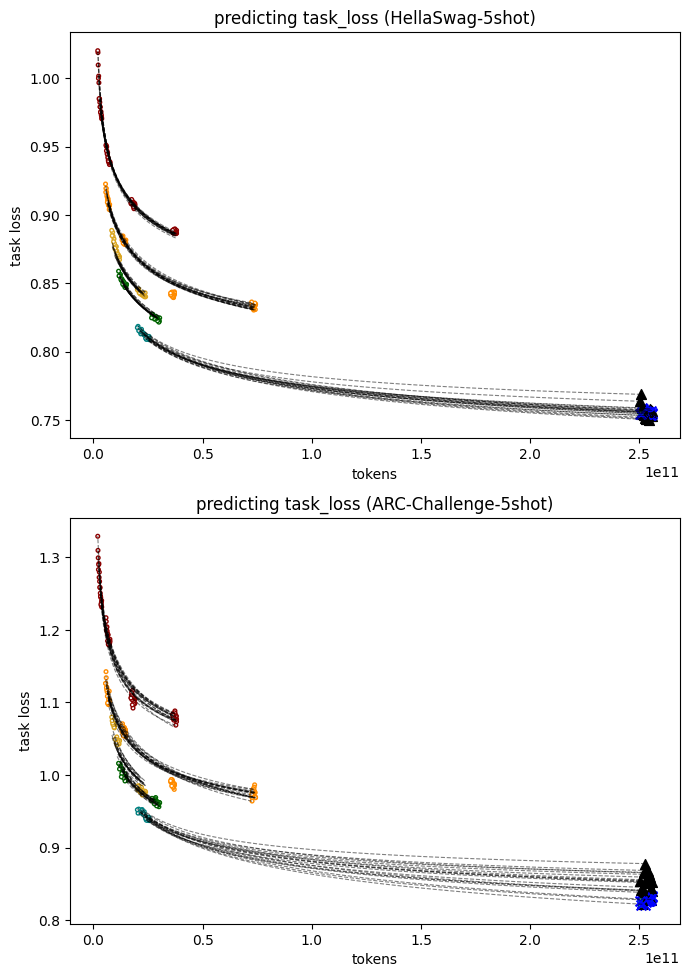

In [8]:
from a_david_noise_utils import get_all_data_by_name, get_dataframe, plot_step1, plot_step2, fit_step1, fit_step2, get_predicted_error, plot_stacked
from a_david_noise_utils import BASELINE_BY_TASK_NAME, TASKS

import matplotlib.pyplot as plt

rows = len(TASKS.keys())

step_1_only = True
if step_1_only:
    fig, axes = plt.subplots(rows, 1, figsize=(7, 5 * rows))
else:
    fig, axes = plt.subplots(rows, 3, figsize=(20, 5 * rows))

SAMPLE_SIZE = 20

step1_error = {}

for configs in all_configs:
    target = [run_name for run_name in configs if configs[run_name].mode == "eval"][0]
    step1_error[target] = {}
    for i, (task_name, task) in enumerate(TASKS.items()):
        observed_preds = []
        observed_actuals = []
        for final_idx in range(1, SAMPLE_SIZE):
            tokens = get_all_data_by_name(configs, ["throughput/total_tokens"])
            bpb_loss = get_all_data_by_name(configs, task['bpb'])
            downstream_loss = get_all_data_by_name(configs, task['score'])
        
            df = get_dataframe(configs, tokens, downstream_loss)
            
            step1_df = get_dataframe(configs, tokens, bpb_loss)

            # Only keep the final result from each run
            step1_df = step1_df.groupby('run').apply(lambda rows: rows.iloc[-final_idx], include_groups=False).reset_index()
            step1_df, coefficients = fit_step1(step1_df)

            # Only plot error for predicted point
            do_plot = "1B-10xC" in configs

            if do_plot:
                plot_step1(
                    step1_df,
                    coefficients,
                    axes[i][0] if len(axes.shape) > 1 else axes[i],
                    x_label="tokens",
                    y_label="task loss",
                    title=f"predicting task_loss ({task_name})",
                    do_label=(final_idx == 1),
                )

            eval_row = step1_df[step1_df["mode"]=="eval"].iloc[-1]
            y_pred = eval_row["predicted_y"]
            y_actual = eval_row["y"]
            observed_preds += [y_pred]
            observed_actuals += [y_actual]
            
        # step1_error[target][task_name] = get_predicted_error(step1_df)
        step1_error[target][task_name] = {
            'observed_preds': observed_preds,
            'observed_actuals': observed_actuals,
        }

    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

In [9]:
import numpy as np
from scipy import stats
from a_david_noise_utils import print_results_table

def calculate_mean_and_ci(x):
    sample_mean = np.mean(x)
    sem = stats.sem(x)
    df = len(x) - 1
    ci = stats.t.interval(confidence=0.95, df=df, loc=sample_mean, scale=sem)
    return sample_mean, ci

def relative_error_with_CI(A, B, confidence_level=0.95):    
    mean_A, mean_B = np.mean(A), np.mean(B)
    std_A, std_B = np.std(A, ddof=1), np.std(B, ddof=1)
    n_A, n_B = len(A), len(B)
    SE_A, SE_B = std_A / np.sqrt(n_A), std_B / np.sqrt(n_B)
    
    RE = abs(mean_A - mean_B) / abs(mean_B)
    delta_RE = RE * np.sqrt((SE_A / abs(mean_A - mean_B))**2 + (SE_B / abs(mean_B))**2)
    
    Z = stats.norm.ppf((1 + confidence_level) / 2)
    CI_lower, CI_upper = RE - Z * delta_RE, RE + Z * delta_RE
    
    return RE, (CI_lower, CI_upper)

results = {}

for task, data in step1_error['1B-10xC'].items():
    pred_mean, pred_ci = calculate_mean_and_ci(data['observed_preds'])
    actual_mean, actual_ci = calculate_mean_and_ci(data['observed_actuals'])
    
    # diff, diff_ci = calculate_difference_and_ci(pred_mean, pred_ci, actual_mean, actual_ci)
    diff, diff_ci = relative_error_with_CI(data['observed_preds'], data['observed_actuals'])
    
    results[task] = {
        'predictions': {
            'mean': pred_mean,
            'ci': pred_ci
        },
        'actuals': {
            'mean': actual_mean,
            'ci': actual_ci
        },
        'difference': {
            'mean': diff,
            'ci': diff_ci
        }
    }

print(f'95% CI across the last 20 checkpoints (in this case, our CI only captures step-to-step variance):')
print_results_table(results)

95% CI across the last 20 checkpoints (in this case, our CI only captures step-to-step variance):


| Task | Predicted Task Loss | Actual Task Loss | Signed Relative Error |
| --- | --- | --- | --- |
| HellaSwag-5shot | 0.756 ± 0.004 | 0.755 ± 0.001 | +0.1% ± 0.5% |
| ARC-Challenge-5shot | 0.850 ± 0.015 | 0.827 ± 0.003 | +2.8% ± 1.6% |

#### Variance around Prediction Target

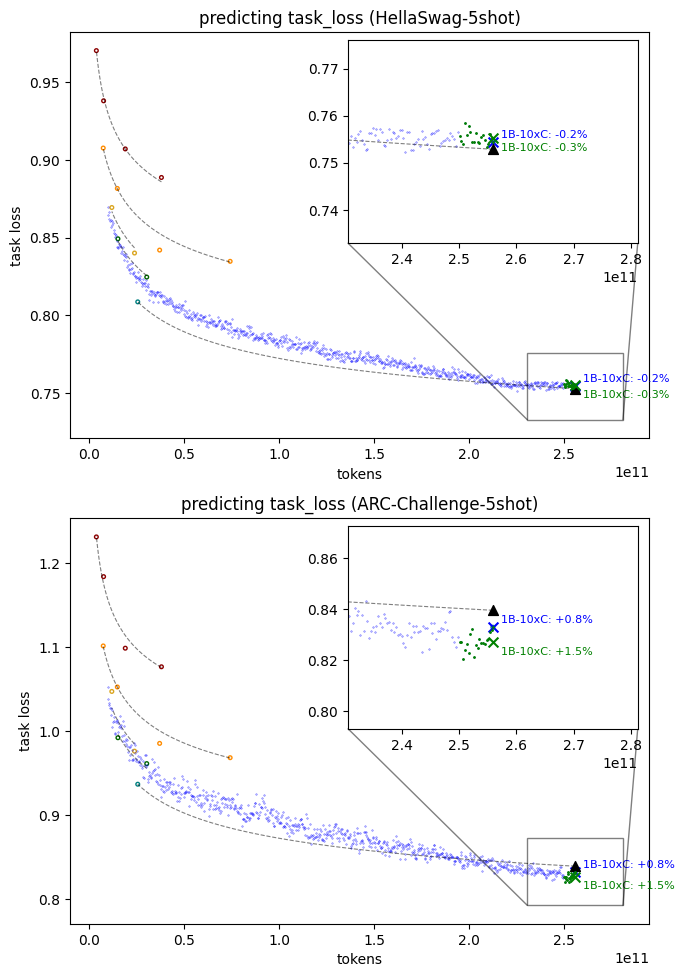

In [114]:
from a_david_noise_utils import get_all_data_by_name, get_dataframe, plot_step1, plot_step2, fit_step1, fit_step2, get_predicted_error, plot_stacked
from a_david_noise_utils import BASELINE_BY_TASK_NAME, TASKS

import matplotlib.pyplot as plt

rows = len(TASKS.keys())

step_1_only = True
if step_1_only:
    fig, axes = plt.subplots(rows, 1, figsize=(7, 5 * rows))
else:
    fig, axes = plt.subplots(rows, 3, figsize=(20, 5 * rows))

SAMPLE_SIZE = 1

step1_error = {}

for configs in all_configs:
    target = [run_name for run_name in configs if configs[run_name].mode == "eval"][0]
    step1_error[target] = {}
    for i, (task_name, task) in enumerate(TASKS.items()):
        observed_preds = []
        observed_actuals = []
        for final_idx in range(1, SAMPLE_SIZE+1):
            tokens = get_all_data_by_name(configs, ["throughput/total_tokens"])
            bpb_loss = get_all_data_by_name(configs, task['bpb'])
            downstream_loss = get_all_data_by_name(configs, task['score'])
        
            df = get_dataframe(configs, tokens, downstream_loss)
            
            step1_df = get_dataframe(configs, tokens, bpb_loss)

            #### 

            observed_actuals = last_n_y.tolist()

            #### 

            # Only keep the final result from each run
            full_step1_df = step1_df.copy()
            step1_df = step1_df.groupby('run').apply(lambda rows: rows.iloc[-final_idx], include_groups=False).reset_index()
            step1_df, coefficients = fit_step1(step1_df)

            # Only plot error for predicted point
            do_plot = "1B-10xC" in configs

            if 'Winogrande' in task_name: full_step1_df = None

            if do_plot:
                plot_step1(
                    step1_df,
                    coefficients,
                    axes[i][0] if len(axes.shape) > 1 else axes[i],
                    x_label="tokens",
                    y_label="task loss",
                    title=f"predicting task_loss ({task_name})",
                    do_label=(final_idx == 1),
                    full_df=full_step1_df
                )

            eval_row = step1_df[step1_df["mode"]=="eval"].iloc[-1]
            y_pred = eval_row["predicted_y"]
            y_actual = eval_row["y"]
            observed_preds += [y_pred]
            # observed_actuals += [y_actual]

        # step1_error[target][task_name] = get_predicted_error(step1_df)
        step1_error[target][task_name] = {
            'observed_preds': observed_preds,
            'observed_actuals': observed_actuals,
        }

    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

In [11]:
def process_step1_error(step1_error):
    step1_error = step1_error.copy()
    for target, tasks in step1_error.items():
        for task, data in tasks.items():
            observed_preds = data['observed_preds']
            observed_actuals = data['observed_actuals']
            
            max_actual = max(observed_actuals)
            min_actual = min(observed_actuals)
            mean_actual = sum(observed_actuals) / len(observed_actuals)
            
            data['observed_preds'] = y_pred = observed_preds[0]  # Assuming there's only one prediction
            
            data.update({
                'max_actual': max_actual,
                'min_actual': min_actual,
                'mean_actual': mean_actual,
                'rel_error_max': (y_pred - max_actual) / max_actual,
                'rel_error_min': (y_pred - min_actual) / min_actual,
                'rel_error_mean': (y_pred - mean_actual) / mean_actual
            })

            del data['observed_actuals']
    
    return step1_error

processed_step1_error = process_step1_error(step1_error)

In [94]:
def print_error_table(processed_error: dict[str, dict]):
    from IPython.display import display, Markdown

    targets = processed_error.keys()
    tasks = next(iter(processed_error.values())).keys()

    headers = ["Task"]
    for target in targets:
        headers.extend([f"Pred Task Loss", "Max", "Min", "Mean", "Max Rel. Error", "Min Rel. Error", "Mean Rel. Error"])
    
    mkdn = "| " + " | ".join(headers) + " |"
    mkdn += "\n|" + "|".join(["---"] * len(headers)) + "|"

    sum_rel_error = {target: {"max": [], "min": [], "mean": []} for target in targets}

    for task in tasks:
        row = [task]
        for target in targets:
            data = processed_error[target][task]
            row.extend([
                f"{data['observed_preds']:.4f}",
                f"{data['max_actual']:.4f}",
                f"{data['min_actual']:.4f}",
                f"{data['mean_actual']:.4f}",
                f"{data['rel_error_max']:.2%}",
                f"{data['rel_error_min']:.2%}",
                f"{data['rel_error_mean']:.2%}"
            ])
            sum_rel_error[target]["max"].append(data['rel_error_max'])
            sum_rel_error[target]["min"].append(data['rel_error_min'])
            sum_rel_error[target]["mean"].append(data['rel_error_mean'])
        mkdn += "\n|" + "|".join(row) + "|"

    # Add average signed error row
    avg_signed_row = ["Avg signed error"]
    for target in targets:
        avg_signed_row.extend([
            "",  # Pred Task Loss (empty)
            "",  # Max (empty)
            "",  # Min (empty)
            "",  # Mean (empty)
            f"{sum(sum_rel_error[target]['max']) / len(tasks):.2%}",
            f"{sum(sum_rel_error[target]['min']) / len(tasks):.2%}",
            f"{sum(sum_rel_error[target]['mean']) / len(tasks):.2%}"
        ])
    mkdn += "\n|" + "|".join(avg_signed_row) + "|"

    # Add average unsigned error row
    avg_unsigned_row = ["Avg unsigned error"]
    for target in targets:
        avg_unsigned_row.extend([
            "",  # Pred Task Loss (empty)
            "",  # Max (empty)
            "",  # Min (empty)
            "",  # Mean (empty)
            f"{sum(abs(x) for x in sum_rel_error[target]['max']) / len(tasks):.2%}",
            f"{sum(abs(x) for x in sum_rel_error[target]['min']) / len(tasks):.2%}",
            f"{sum(abs(x) for x in sum_rel_error[target]['mean']) / len(tasks):.2%}"
        ])
    mkdn += "\n|" + "|".join(avg_unsigned_row) + "|"

    display(Markdown(mkdn))

print('Results over last 10 checkpoints of acutal 1B-10xC results:')
print_error_table(processed_step1_error)

Results over last 10 checkpoints of acutal 1B-10xC results:


| Task | Pred Task Loss | Max | Min | Mean | Max Rel. Error | Min Rel. Error | Mean Rel. Error |
|---|---|---|---|---|---|---|---|
|HellaSwag-5shot|0.7528|0.7561|0.7534|0.7548|-0.43%|-0.07%|-0.26%|
|ARC-Challenge-5shot|0.8395|0.8329|0.8246|0.8285|0.80%|1.81%|1.34%|
|Avg signed error|||||0.18%|0.87%|0.54%|
|Avg unsigned error|||||0.62%|0.94%|0.80%|